# CHEM277B Homework 8
### Trevor Oldham


### (A)

Importing the MNIST Data and printing out relevant dimensions

In [139]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

training_set, validation_set = pd.read_pickle('mnist.pkl')

#examine the shape of the training set
print(len(training_set[0]))
print(len(training_set[0][0]))
print(len(training_set[0][0][0]))
print(len(validation_set[0]))

#normalized the training data and reshape to shape (ndata, nfeatures)
gray_img_train = np.array(training_set[0]).astype('uint8')
gray_img_train = gray_img_train.reshape(60000, 32, 32)
rgb_img_train = np.zeros((60000, 32, 32, 3))
for i in range(len(gray_img_train[0])):
  rgb_img_train[i] = cv2.cvtColor(gray_img_train[i],  cv2.COLOR_GRAY2RGB)
print(gray_img_train.shape)
print(rgb_img_train.shape)
rgb_img_train = np.transpose(rgb_img_train, (0, 3, 1, 2))  # (60000, 3, 32, 32)
normalized_train_set_x = rgb_img_train / 255
print(normalized_train_set_x.shape)

plt.show()

gray_img_test = np.array(validation_set[0]).astype('uint8')
gray_img_test = gray_img_test.reshape(10000, 32, 32)
rgb_img_test = np.zeros((10000, 32, 32, 3))
for i in range(len(gray_img_test[0])):
  rgb_img_test[i] = cv2.cvtColor(gray_img_test[i],  cv2.COLOR_GRAY2RGB)
print(gray_img_test.shape)
print(rgb_img_test.shape)
rgb_img_test = np.transpose(rgb_img_test, (0, 3, 1, 2))  # (10000, 3, 32, 32)
normalized_test_set_x = rgb_img_test / 255
print(normalized_test_set_x.shape)

train_set_y = np.array(training_set[1])
test_set_y = np.array(validation_set[1])

60000
32
32
10000
(60000, 32, 32)
(60000, 32, 32, 3)
(60000, 3, 32, 32)
(10000, 32, 32)
(10000, 32, 32, 3)
(10000, 3, 32, 32)


Calculate the size of the output after each convolution sequentially applied to the black and white 32x32 image.

(i). Convolution Filter size of 2x2, number of filters 33, stride of 2, padding of 0

(ii). Convolution Filter size of 3x3, number of filters 55, stride of 1, padding of 1

(iii). Convolution Filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a Max
Pooling with filter size of 2x2 and stride 2

Using the equation below:

$$ \frac{I - K + 2P}{S} + 1 $$

where I is the input dimension (32), K is the size of the filter, P is the size of the padding, and S is the stride.

(i) $$ \frac{32 - 2 + 2(0)}{2} + 1 = 16$$

So in this case we get a 16x16 image for each of the 33 feature maps.

(ii) $$ \frac{16 - 3 + 2(1)}{1} + 1 = 16$$

This case returns a 16x16 image for each of the 55 feature maps.

(iii) $$ \frac{16 - 3 + 2(1)}{1} + 1 = 16$$

Then we apply the max pooling operation with 2x2 filter and stride 2:

$$ \frac{16 - 2 + 2(0)}{2} + 1 = 8$$

Which yields an 8x8 image for each of the 77 feature maps.

### (B)

The MNIST data set was, in fact, in color (RGB). This means the depth of the input image would
be 3. Calculate the dimensionality of the output for the following convolutions sequentially applied to a
RGB MNIST input:

(i). Convolution Filter size of 2x2, number of filters 33, stride of 2, padding of 0

(ii). Convolution Filter size of 3x3, number of filters 55, stride of 1, padding of 1. Followed by a max
pooling layer of kernel size 3x3, stride of 1, padding of 0

(iii). Convolution Filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a Max
Pooling with filter size of 2x2 and stride 2.

(i) $$ \frac{32 - 2 + 2(0)}{2} + 1 = 16$$

This convolution yields a 16x16x3 image for each 33 filters.

(ii)

$$ \frac{16 - 3 + 2(1)}{1} + 1 = 16$$

Followed by a max pooling layer with F=3, S = 1, we use the equation below:

$$ H2 =  \frac{H1 - F}{S} + 1$$
$$ H2 =  \frac{16 - 3}{1} + 1 = 14$$

The calculation for the width is the same and thus we have a 14x14x3 image for each of the 55 filters.


(iii)

$$ \frac{14 - 3 + 2(1)}{1} + 1 = 14$$

Followed by a max pooling layer with F=2, S = 2, we use the equation below:

$$ H2 =  \frac{H1 - F}{S} + 1$$
$$ H2 =  \frac{14 - 2}{2} + 1 = 7$$

So this layer yields an image of 7x7x3 for each of the 77 filters.


# (C)


In [140]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [141]:
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split, KFold

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform
        self.learning_rate = learning_rate


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.long)
        val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
        val_outputs = torch.tensor(val_outputs, dtype=torch.long)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model.forward(batch_input)
                loss_func = nn.CrossEntropyLoss()
                loss = loss_func(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    self.optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate, weight_decay = 1e-5)
                    loss = loss_func(batch_predictions, batch_output)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
            epoch_loss, epoch_acc = self.evaluate(inputs, outputs)  
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss.detach().numpy())
            accuracies.append(epoch_acc)
            val_losses.append(val_loss.detach().numpy())
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=False):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """

        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.long)

        loss_func = nn.CrossEntropyLoss()
        
        pred = self.model.forward(inputs)

        losses = loss_func(pred, outputs)
        #print("pred = ", pred)
        #print("truth = " ,outputs)
        
        sum = 0
        for i in range(len(outputs)):
          if outputs[i] == torch.argmax(pred[i]):
            sum += 1
        acc = sum / len(outputs)
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [142]:
from torch import nn
import torch
class ConvMLP(nn.Module):
    def __init__(self):
        super(ConvMLP, self).__init__()
        self.conv = nn.Conv2d(3, 3, kernel_size = 5, stride=1, padding = 2)
        self.fc = nn.Linear(3*32*32, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.conv(x))
        x = nn.Flatten()(x)
        x = self.activation(self.fc(x))
        return x

In [143]:
from torchsummary import summary
model = ConvMLP()
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]             228
              ReLU-2            [-1, 3, 32, 32]               0
            Linear-3                   [-1, 10]          30,730
              ReLU-4                   [-1, 10]               0
Total params: 30,958
Trainable params: 30,958
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.12
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


In [144]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
def Kfold_validation(n, inputs, outputs):

    total_num=len(inputs)
    kf=KFold(n_splits=n,shuffle=True)


    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs= inputs[train_selector]
        test_Xs=  inputs[test_selector]
        train_ys= outputs[train_selector]
        test_ys= outputs[test_selector]

        model = ConvMLP()
        t = Trainer(model, optimizer_type='adam', learning_rate=1e-3, epoch=30, batch_size=64, input_transform=lambda x: x,)
        train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys, train_size = 0.666)
        
        dictionary = t.train(train_in, train_real, val_in, val_real,early_stop=True,l2=False,silent=False)

    return dictionary, model

In [145]:
dictionary, model = Kfold_validation(3, normalized_train_set_x[0:1000], train_set_y[0:1000])

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-141-5a654197e45b>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-141-5a654197e45b>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)
  7%|▋         | 2/30 [00:00<00:03,  7.84it/s]

Epoch 1/30 - Loss: 2.299 - Acc: 0.102
              Val_loss: 2.301 - Val_acc: 0.103


 40%|████      | 12/30 [00:01<00:02,  7.90it/s]

Epoch 11/30 - Loss: 2.282 - Acc: 0.122
              Val_loss: 2.295 - Val_acc: 0.126


 73%|███████▎  | 22/30 [00:02<00:00,  8.01it/s]

Epoch 21/30 - Loss: 2.281 - Acc: 0.122
              Val_loss: 2.292 - Val_acc: 0.126


func:'train'  took: 3.8070 sec


  3%|▎         | 1/30 [00:00<00:03,  8.41it/s]

Epoch 1/30 - Loss: 2.301 - Acc: 0.117
              Val_loss: 2.305 - Val_acc: 0.090


 40%|████      | 12/30 [00:01<00:02,  6.09it/s]

Epoch 11/30 - Loss: 2.272 - Acc: 0.122
              Val_loss: 2.314 - Val_acc: 0.094


 73%|███████▎  | 22/30 [00:03<00:01,  6.72it/s]

Epoch 21/30 - Loss: 2.271 - Acc: 0.122
              Val_loss: 2.318 - Val_acc: 0.099


func:'train'  took: 4.5425 sec


  3%|▎         | 1/30 [00:00<00:03,  7.63it/s]

Epoch 1/30 - Loss: 2.301 - Acc: 0.101
              Val_loss: 2.303 - Val_acc: 0.090


 40%|████      | 12/30 [00:01<00:02,  7.92it/s]

Epoch 11/30 - Loss: 2.281 - Acc: 0.128
              Val_loss: 2.301 - Val_acc: 0.135


 73%|███████▎  | 22/30 [00:02<00:00,  8.18it/s]

Epoch 21/30 - Loss: 2.280 - Acc: 0.128
              Val_loss: 2.304 - Val_acc: 0.135


func:'train'  took: 3.7226 sec


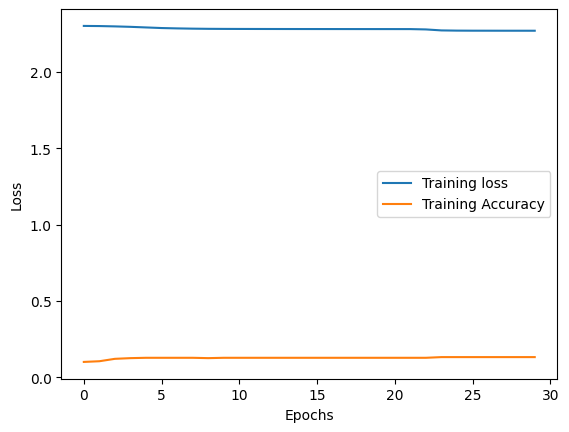

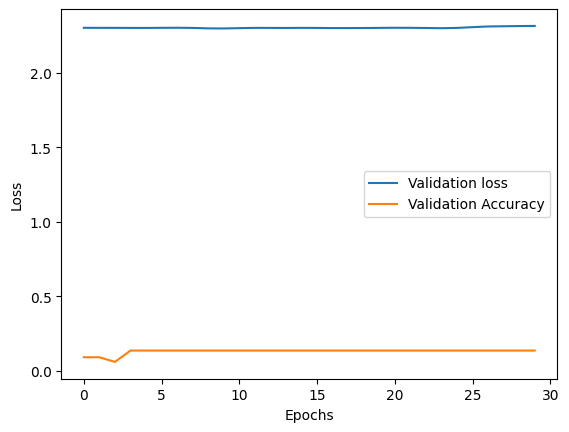

In [146]:

losses = dictionary['losses']
accuracies = dictionary['accuracies']
accuracies = np.asarray(accuracies)
losses = np.asarray(losses)
plt.figure()
plt.plot(np.arange(len(losses)),losses,label='Training loss')
plt.plot(np.arange(len(accuracies)),accuracies,label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

val_losses = dictionary['val_losses']
val_accuracies = dictionary['val_accuracies']
val_accuracies = np.asarray(val_accuracies)
val_losses = np.asarray(val_losses)
plt.figure()
plt.plot(np.arange(len(val_losses)),val_losses,label='Validation loss')
plt.plot(np.arange(len(val_accuracies)),val_accuracies,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()    


In [147]:
#feed forward into the model with the test data from MNIST and compare the results to the true y values
output = model.forward(torch.tensor(normalized_test_set_x, dtype = torch.float32))
sum = 0
for i in range(len(output)):
  if (test_set_y[i] == torch.argmax(output[i])):
    sum += 1
print(sum/len(output))

0.1034


### (D)

In [148]:
class ConvMLP2(nn.Module):
    def __init__(self):
        super(ConvMLP2, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                  nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)])
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.ModuleList([nn.Linear(16 * 8 * 8, 128), nn.Linear(128, 10)])
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.activation(self.conv[0](x)))
        x = self.pool(self.activation(self.conv[1](x)))
        x = nn.Flatten()(x)
        x = self.activation(self.fc[0](x))
        x = self.activation(self.fc[1](x))
        return x

In [149]:
model = ConvMLP2()
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]           2,320
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Linear-7                  [-1, 128]         131,200
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
             ReLU-10                   [-1, 10]               0
Total params: 135,258
Trainable params: 135,258
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.35
Params size (MB): 0.52
Estimated T

In [150]:
def Kfold_validation_2(n, inputs, outputs):

    total_num=len(inputs)
    kf=KFold(n_splits=n,shuffle=True)


    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs= inputs[train_selector]
        test_Xs=  inputs[test_selector]
        train_ys= outputs[train_selector]
        test_ys= outputs[test_selector]

        model = ConvMLP2()
        t = Trainer(model, optimizer_type='adam', learning_rate=1e-3, epoch=30, batch_size=128, input_transform=lambda x: x,)
        train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys, train_size = 0.666)
        
        dictionary = t.train(train_in, train_real, val_in, val_real,early_stop=False,l2=False,silent=False)

    return dictionary, model

In [151]:
dictionary, model = Kfold_validation_2(3, normalized_train_set_x[0:1000], train_set_y[0:1000])


  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-141-5a654197e45b>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-141-5a654197e45b>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)
  3%|▎         | 1/30 [00:00<00:08,  3.36it/s]

Epoch 1/30 - Loss: 2.301 - Acc: 0.120
              Val_loss: 2.300 - Val_acc: 0.130


 37%|███▋      | 11/30 [00:02<00:04,  4.58it/s]

Epoch 11/30 - Loss: 2.300 - Acc: 0.120
              Val_loss: 2.301 - Val_acc: 0.112


 70%|███████   | 21/30 [00:05<00:02,  3.24it/s]

Epoch 21/30 - Loss: 2.300 - Acc: 0.120
              Val_loss: 2.301 - Val_acc: 0.112


func:'train'  took: 7.7381 sec


  3%|▎         | 1/30 [00:00<00:06,  4.73it/s]

Epoch 1/30 - Loss: 2.298 - Acc: 0.126
              Val_loss: 2.301 - Val_acc: 0.099


 37%|███▋      | 11/30 [00:02<00:04,  4.64it/s]

Epoch 11/30 - Loss: 2.271 - Acc: 0.144
              Val_loss: 2.306 - Val_acc: 0.126


 70%|███████   | 21/30 [00:04<00:01,  4.64it/s]

Epoch 21/30 - Loss: 2.253 - Acc: 0.144
              Val_loss: 2.300 - Val_acc: 0.126


func:'train'  took: 6.4801 sec


  3%|▎         | 1/30 [00:00<00:06,  4.75it/s]

Epoch 1/30 - Loss: 2.301 - Acc: 0.119
              Val_loss: 2.304 - Val_acc: 0.090


 37%|███▋      | 11/30 [00:02<00:04,  3.83it/s]

Epoch 11/30 - Loss: 2.281 - Acc: 0.131
              Val_loss: 2.308 - Val_acc: 0.117


 70%|███████   | 21/30 [00:05<00:02,  3.87it/s]

Epoch 21/30 - Loss: 2.255 - Acc: 0.133
              Val_loss: 2.304 - Val_acc: 0.117


func:'train'  took: 7.4687 sec


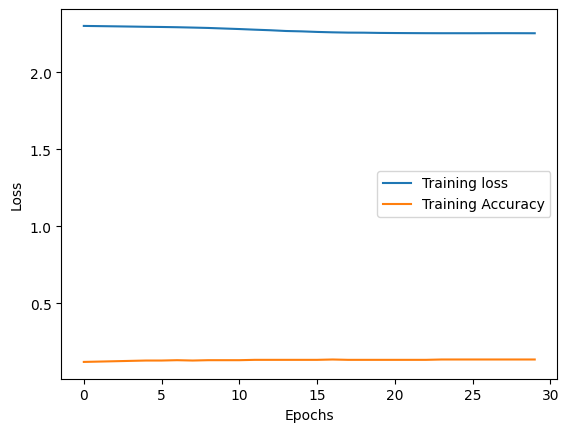

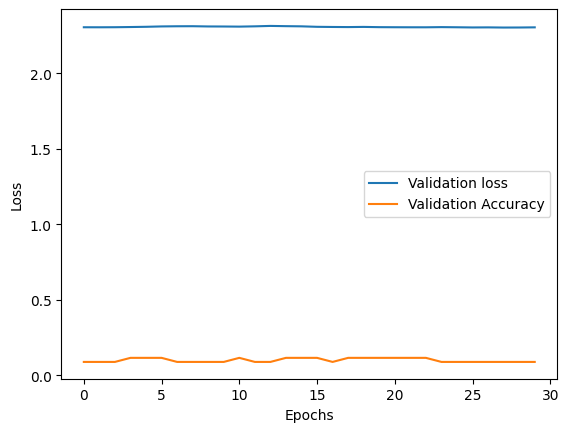

In [152]:

losses = dictionary['losses']
accuracies = dictionary['accuracies']
accuracies = np.asarray(accuracies)
losses = np.asarray(losses)
plt.figure()
plt.plot(np.arange(len(losses)),losses,label='Training loss')
plt.plot(np.arange(len(accuracies)),accuracies,label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

val_losses = dictionary['val_losses']
val_accuracies = dictionary['val_accuracies']
val_accuracies = np.asarray(val_accuracies)
val_losses = np.asarray(val_losses)
plt.figure()
plt.plot(np.arange(len(val_losses)),val_losses,label='Validation loss')
plt.plot(np.arange(len(val_accuracies)),val_accuracies,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()